<center>
<h1>Mining the Bible verses</h1>
<h2>A practitioner's exploration into what’s possible using text mining on religious corpora.</h2>
<h3>Arian Pasquali</h3>
<h4>heavily based on J. Monteiro's work (https://github.com/jmmonteiro) </h4>
<h3>Porto, Novembro 2018</h3>
</center>

The bible verses corpora is a well structure dataset that offers interesting opportunities to test different NLP methods. This notebook is an attempt to explore some fun topics. I hope to apply the same techniques using other religious corpora in the future.

## Load dependencies

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install gensim
!pip install nltk

## Load packages
The first step is to load some of the packages necessary to run the analysis. The last line specifies the size of the plots that will be displayed.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14,10)

In [15]:
#ignore some warnings
import warnings; warnings.simplefilter('ignore')

## Load data

Let's start by loading the data and checking how many samples we have.

In [2]:
bible = pd.read_csv('./corpus/bible_data_set.csv')
bible.shape

(31102, 5)

Next, we'll encode some extra information about the verses, namely, which testament and book they belong to. A quick google search tells us which books are contained in the KJV.

In [3]:
# Books in the Old Testament (OT) and New Testament (NT)
OT_books = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges',
            'Ruth', '1 Samuel', '2 Samuel', '1 Kings', '2 Kings', '1 Chronicles', '2 Chronicles',
            'Ezra', 'Nehemiah', 'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
            'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel', 'Daniel',
            'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah', 'Nahum', 'Habakkuk',
            'Zephaniah', 'Haggai',    'Zechariah',    'Malachi']

NT_books = ['Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans', '1 Corinthians',
            '2 Corinthians', 'Galatians', 'Ephesians', 'Philippians', 'Colossians',
            '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy', 'Titus', 'Philemon',
            'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John', '3 John', 'Jude',
            'Revelation']

# New variables with the books and testaments as categories
books = pd.unique(bible.book)
book_codes = np.arange(1,len(books)+1)
book_codes = np.concatenate([books.reshape((-1,1)),book_codes.reshape((-1,1))], axis=1)

bible['book_code'] = np.nan
bible['testament'] = ''
bible['testament_code'] = np.nan
for i in range(0,bible.shape[0]):
    ind = bible.at[i,'book'] == book_codes[:,0]
    bible.at[i,'book_code'] = book_codes[ind,1]
    
    if bible.at[i,'book'] in OT_books:
        bible.at[i,'testament'] = 'Old Testament'
        bible.at[i,'testament_code'] = 0
    elif bible.at[i,'book'] in NT_books:
        bible.at[i,'testament'] = 'New Testament'
        bible.at[i,'testament_code'] = 1
    else:
        raise Exception('Book not found: ' + bible.at[i,'book'])

bible.book_code = bible.book_code.astype(int)
bible.book_code = pd.Categorical(bible.book_code)
bible.testament_code = bible.testament_code.astype(int)
bible.testament_code = pd.Categorical(bible.testament_code)
    
bible.head()

,citation,book,chapter,verse,text,book_code,testament,testament_code
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,1,Old Testament,0
1,Genesis 1:2,Genesis,1,2,"And the earth was without form, and void; and ...",1,Old Testament,0
2,Genesis 1:3,Genesis,1,3,"And God said, Let there be light: and there wa...",1,Old Testament,0
3,Genesis 1:4,Genesis,1,4,"And God saw the light, that it was good: and G...",1,Old Testament,0
4,Genesis 1:5,Genesis,1,5,"And God called the light Day, and the darkness...",1,Old Testament,0


Before starting the analysis, I'll permute the data. This will break the order of the verses, preventing cases in which a structured chunk of the data (e.g. a chapter) is contained completely on the train set or on the test set. In other words, we want to have the chapters spread around the cross-validation folds.

In order to avoid problems with the cross-validation later on, I'll reset the index as well.

In [4]:
bible = bible.sample(frac=1, random_state=7).reset_index(drop=True)
bible.head()

,citation,book,chapter,verse,text,book_code,testament,testament_code
0,Psalms 12:2,Psalms,12,2,They speak vanity every one with his neighbour...,19,Old Testament,0
1,Ruth 2:7,Ruth,2,7,"And she said, I pray you, let me glean and gat...",8,Old Testament,0
2,Ezekiel 33:10,Ezekiel,33,10,"Therefore, O thou son of man, speak unto the h...",26,Old Testament,0
3,Psalms 139:1,Psalms,139,1,"O lord, thou hast searched me, and known me. \n",19,Old Testament,0
4,Judges 9:34,Judges,9,34,"And Abimelech rose up, and all the people that...",7,Old Testament,0


Looking good so far. Time for some machine learning.

## Old Testament vs. New Testament

The first task will be straightforward: classify which verses belong to the Old Testament (OT), and which verses belong to the New Testament (NT).

The first thing that one notices is that the OT is larger than the NT.

In [5]:
print('# verses in the OT: ' + str(np.sum(bible.testament_code==0)))
print('# verses in the NT: ' + str(np.sum(bible.testament_code==1)))

# verses in the OT: 23145
# verses in the NT: 7957


This means that we should probably do 2 things:

1. Use a classifier which takes the class imbalance into account. In this case, we will use a [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine) classifier with class weights to account for the class imbalance.

2. Use the *balanced accuracy* metric, instead of the overall accuracy. This simply corresponds to the average of the class accuracies.

The reason for the second point is easy to explain.

Imagine that you had a dataset comprised of 90% of samples in class A, and 10% in class B. If a machine learning model classified every sample as class A, the overall accuracy would be 90%. However, if you look at the balanced accuracy, it would be (100%+0%)/2 = 50%. The first metric might lead someone (at first glance) to think that the method was working well, whereas the second metric clearly indicates that the method does not generalise well.

We'll also use a StratifiedKFold cross-validation strategy, in order to preserve the ratio of the samples per class across the folds.

### Defining SVM model setup and weighted vector space model with TF.IDF 

In [6]:
X = bible.text
y = np.asarray(bible.testament_code)

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

clf = LinearSVC(class_weight='balanced', loss='squared_hinge')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# using count vectorized
# vect = CountVectorizer(ngram_range=(1,3),

#                         token_pattern='(?u)(?:\\b|(?<=_))[^\W_][^\W_-]+(?:\\b|(?=[_-]))')

# using TF.IDF
vect = TfidfVectorizer(
    sublinear_tf=True,
    ngram_range=(1,3),
    token_pattern='(?u)(?:\\b|(?<=_))[^\W_][^\W_-]+(?:\\b|(?=[_-]))'
)

In [8]:
n_cv_folds = 10

# Use the stratified KFold strategy, in order to preserve the proportion of each class in all the folds
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=n_cv_folds)

acc = []
class_acc = []

#folds = []
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

    
    X_train = vect.fit_transform(X_train)
    X_test = vect.transform(X_test)
    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    # General accuracy
    acc.append(accuracy_score(y_test,y_pred))
    
    # Class accuracy
    ind = y_test == 0
    OT_acc = np.sum(y_test[ind] == y_pred[ind])
    OT_acc = OT_acc/np.sum(ind)
    
    ind = y_test == 1
    NT_acc = np.sum(y_test[ind] == y_pred[ind])
    NT_acc = NT_acc/np.sum(ind)
    
    #folds.append({"y_pred":y_pred,"y_test":y_test})
        
    class_acc.append([OT_acc, NT_acc])

Let's look at the accuracies.

In [9]:
class_acc = np.array(class_acc)
print('Accuracy: ' + str(np.mean(acc)))
print('Balanced Accuracy: ' + str(np.mean(class_acc[:])))

Accuracy: 0.952221840288059
Balanced Accuracy: 0.9314457203912717


Confusion matrix, without normalization
[[2249   65]
 [  95  700]]
Normalized confusion matrix
[[0.97 0.03]
 [0.12 0.88]]


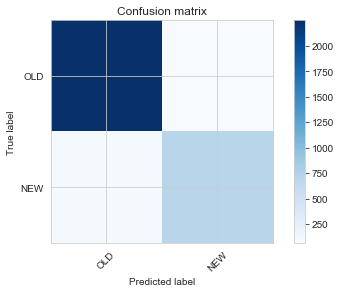

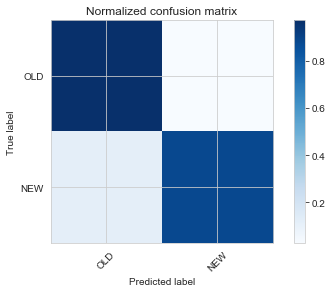

In [10]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = ["OLD","NEW"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                       title='Normalized confusion matrix')

plt.show()


They are both quite similar, maybe due to the fact that SVM is already accounting for the class imbalance. If you omit the ``class_weight='balanced'`` option, the difference between the two will increase.

## Word embeddings
Explore word embeddings comparing OLD Testament and NEW Testament.

In [11]:
import gensim # for Word2Vec
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize


first_testament = bible[bible.testament_code==0]
second_testament = bible[bible.testament_code==1]

print(first_testament.shape)
print(second_testament.shape)

first_testament_verses = [word_tokenize(verse.lower()) for verse in first_testament.text]
second_testament_verses = [word_tokenize(verse.lower()) for verse in second_testament.text]

(23145, 8)
(7957, 8)


In [12]:
%time first_word2vec_model = gensim.models.Word2Vec(first_testament_verses, size=100, window=5, min_count=5)
%time second_word2vec_model = gensim.models.Word2Vec(second_testament_verses, size=100, window=5, min_count=5)

CPU times: user 6.45 s, sys: 168 ms, total: 6.61 s
Wall time: 3.54 s
CPU times: user 1.59 s, sys: 5 ms, total: 1.59 s
Wall time: 696 ms


In [16]:
print(first_word2vec_model)

first_word2vec_model.most_similar("god", topn=10)

Word2Vec(vocab=4467, size=100, alpha=0.025)


[('hosts', 0.7884540557861328),
 ('lord', 0.7709070444107056),
 ('thus', 0.6982283592224121),
 ('voice', 0.6952710747718811),
 ('word', 0.691666305065155),
 ('covenant', 0.6781097650527954),
 ('glory', 0.6755709052085876),
 ('fear', 0.6697150468826294),
 ('name', 0.6507924199104309),
 ('redeemer', 0.6338857412338257)]

In [17]:
print(second_word2vec_model)

second_word2vec_model.most_similar("god", topn=10)

Word2Vec(vocab=2229, size=100, alpha=0.025)


[('faith', 0.9534375667572021),
 ('our', 0.952335774898529),
 ('grace', 0.9519884586334229),
 ('name', 0.9290701746940613),
 ('gospel', 0.9246401786804199),
 ('spirit', 0.9238529205322266),
 ('glory', 0.9231889843940735),
 ('life', 0.9063910245895386),
 ('law', 0.9060491323471069),
 ('world', 0.898612380027771)]

# Conclusion

Interesting enough, comparing the FIRST and the NEW Testament the most similar words related to GOD we can see that **Fear** appears in the first, while love-realted works**faith** 